In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
workers = 8
ngpu = 1
beta1 = 0.5
lr = 0.0002
bs = 60
epochs = 60

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size = 3, padding = 1)
        
        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv1(xb))
        xb = torch.sigmoid(self.conv2(xb))       

        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x, b_y))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess)
valid_dl = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.6693750739097595
1 0.6264200210571289
2 0.5676660060882568
3 0.49824717044830324
4 0.43450764417648313
5 0.3875370562076569
6 0.35629270076751707
7 0.3351499021053314
8 0.31967413425445557
9 0.30735748410224917
10 0.29692553281784057
11 0.2877708554267883
12 0.2796494662761688
13 0.2725204348564148
14 0.2664313673973083
15 0.2614110827445984
16 0.25739014744758604
17 0.25419831871986387
18 0.2516318202018738
19 0.24951988458633423
20 0.24774489998817445
21 0.24623001515865325
22 0.24492241442203522
23 0.24378305971622466
24 0.24278182685375213
25 0.24189500510692596
26 0.24110378921031952
27 0.2403929799795151
28 0.2397502839565277
29 0.23916561901569366
30 0.23863067328929902
31 0.23813852667808533
32 0.23768336772918702
33 0.23726032972335814
34 0.2368652880191803
35 0.23649471402168273
36 0.23614566922187805
37 0.23581547737121583
38 0.2355019509792328
39 0.23520316779613495
40 0.23491741120815277
41 0.23464323580265045
42 0.23437934517860412
43 0.2341246038675308
44 0.233878076

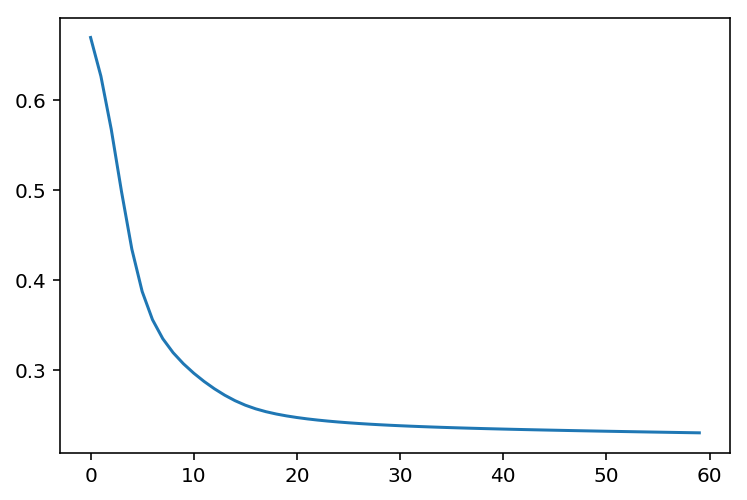

In [14]:
plt.plot(val_losses)
plt.show()

In [15]:
torch.save(model, "SR_model_2.0.ml")

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SuperResolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>